In [33]:
import numpy as np
import os
import pandas as pd
import re
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
from os.path import expanduser
from os.path import join
from sklearn.utils.linear_assignment_ import linear_assignment

from cogspaces.datasets.utils import fetch_mask

from joblib import Memory, Parallel, delayed


idx = pd.IndexSlice



def relative_stability(comp1, comp2):
    comp1 = comp1 / np.sqrt(np.sum(comp1 ** 2, axis=1, keepdims=True))
    comp2 = comp2 / np.sqrt(np.sum(comp2 ** 2, axis=1, keepdims=True))
    Q = comp1.dot(comp2.T)
    assign = linear_assignment(-np.abs(Q))[:, 1]
    Q = Q[:, assign]
    return np.abs(np.diag(Q)).tolist(), assign.tolist()


def compute_stabilities(components):
    res = Parallel(n_jobs=10, verbose=10)(delayed(relative_stability)(
        this_comp, other_comp)
                        for this_comp in components for other_comp in components)

    all_stability = []
    all_assign = []
    n = len(components)
    for this_comp in components:
        stability = []
        assign = []
        for other_comp in components:
            if other_comp is not this_comp:
                this_stability, this_assign = res[0]
                stability.append(this_stability)
                assign.append(this_assign)
            res = res[1:]
        all_stability.append(stability)
        all_assign.append(assign)
    all_stability = np.array(all_stability)
    all_assign = np.array(all_assign)
    return all_stability, all_assign

mem = Memory(cachedir=expanduser('~/cache_local'))
output_dir = expanduser('~/output_pd/cogspaces/full_long')


components = []
snrs = []
regex = re.compile(r'[0-9]+$')
for this_dir in filter(regex.match, os.listdir(output_dir)):
    this_exp_dir = join(output_dir, this_dir)
    component = join(this_exp_dir, 'maps', 'components.nii.gz')
    snr = join(this_exp_dir, 'maps', 'snr.nii.gz')
    if os.path.exists(component) and os.path.exists(snr):
        components.append(component)
        snrs.append(snr)

mask = fetch_mask()['hcp']

masker = MultiNiftiMasker(mask_img=mask, memory=mem, n_jobs=10, memory_level=1).fit()

components = masker.transform(components[:10])

stabilities, assign = compute_stabilities(components)

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   21.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   26.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   31.5s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   37.3s remaining:    3.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   40.6s finished


In [34]:
mean = stabilities.mean(axis=1)

sort = np.argsort(mean.ravel())[::-1]
indices = np.unravel_index(sort, mean.shape)

In [35]:
indices = np.concatenate([index[:, None] for index in indices], axis=1)

In [36]:
print(mean.max())

0.4686627189318339


In [37]:
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from nilearn.plotting import find_xyz_cut_coords

0.4686627189318339
0.45516711473464966
0.45129017697440255
0.4361652996804979
0.4325467083189223
0.42933062381214565
0.42786644564734566
0.4239341848426395
0.4231318202283647
0.42231491539213395
0.41487278209792244
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0., ..., 0.], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e70fe9b70>)
___________________________________________________________unmask - 0.1s, 0.0min
0.4102618628078037
0.40941526492436725
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0., ..., 0.], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e70fe9b70>)
___________________________________________________________unmask - 0.1s, 0.0min
0.4040154715379079
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmas

/home/parietal/amensch/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.38523637917306686
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.000684, ..., -0.      ], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e70fe9b70>)
___________________________________________________________unmask - 0.1s, 0.0min
0.3830549418926239
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.      , ..., 0.002877], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e70fe9b70>)
___________________________________________________________unmask - 0.1s, 0.0min
0.3789342807398902
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0., ..., -0.], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e70fe9b70>)
___________________________________________________________unmask - 0.1s, 0.0min
0.

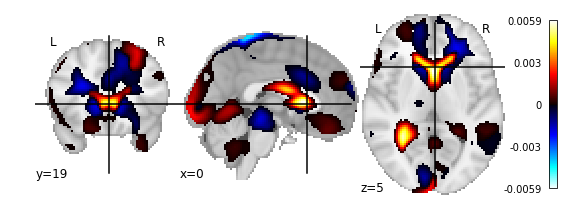

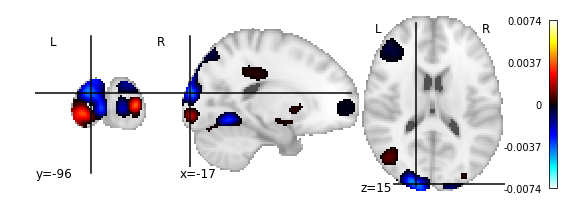

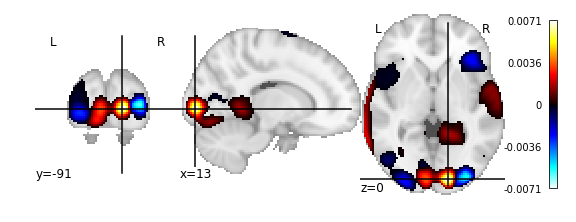

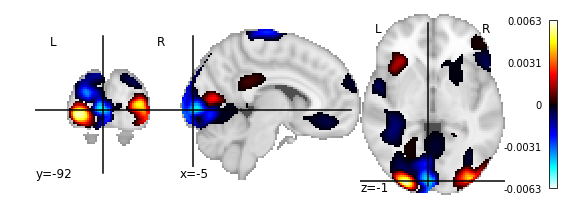

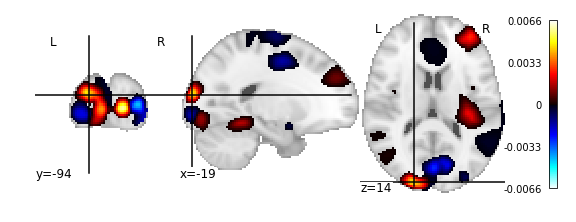

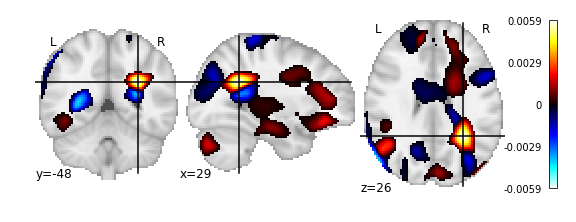

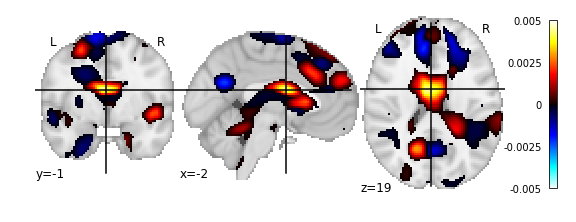

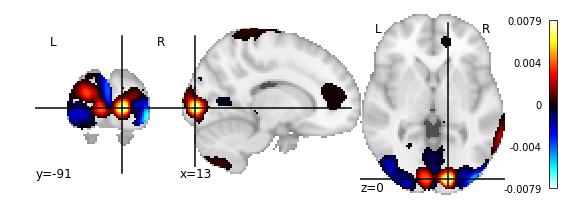

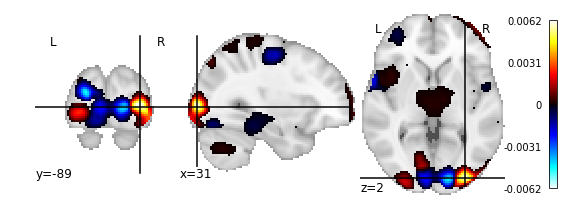

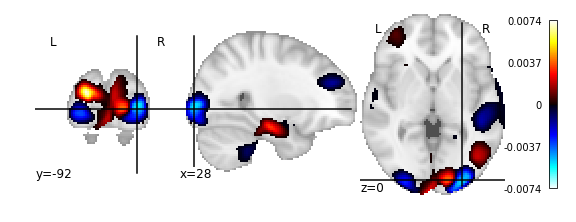

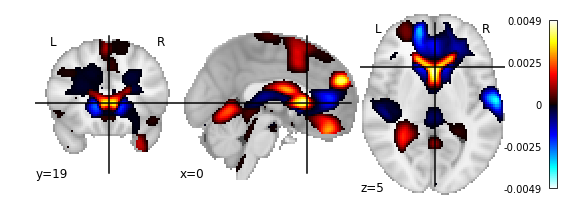

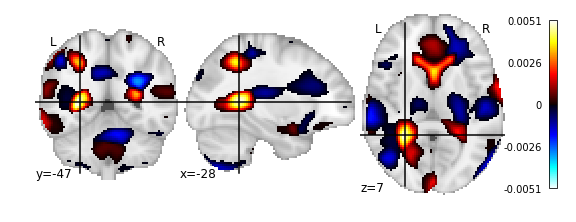

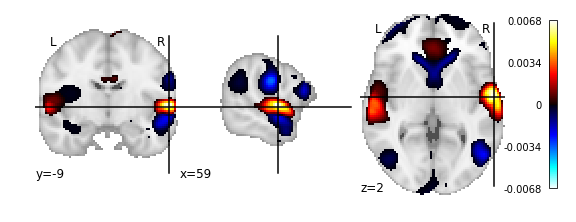

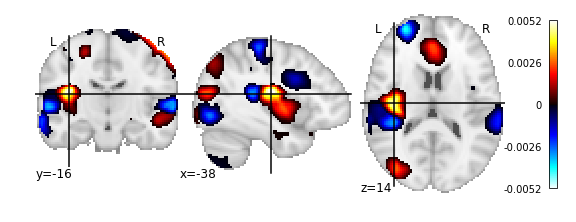

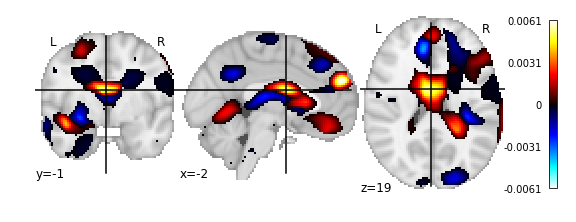

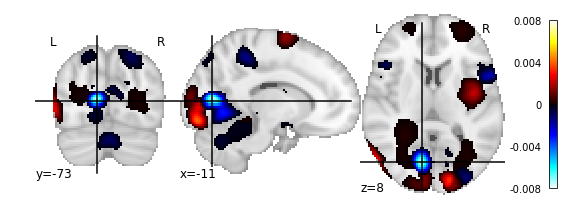

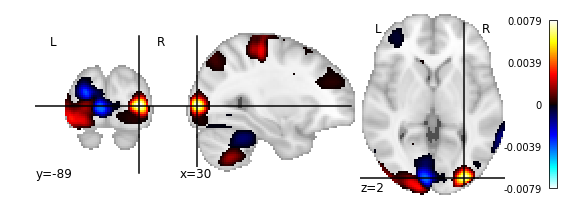

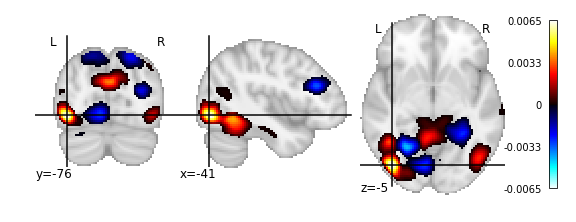

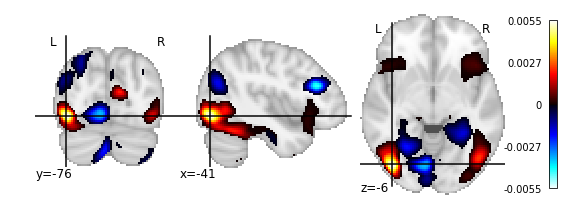

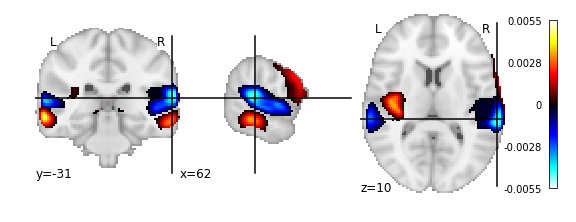

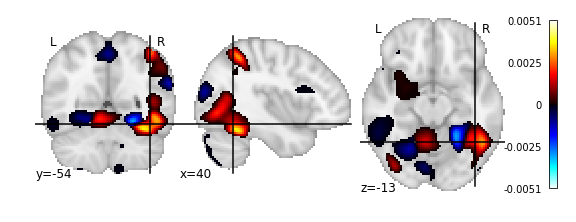

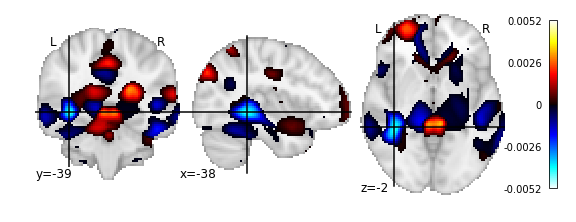

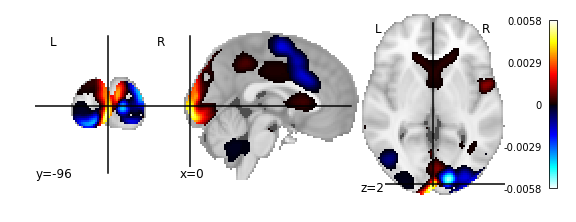

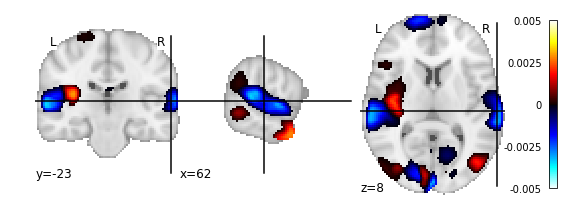

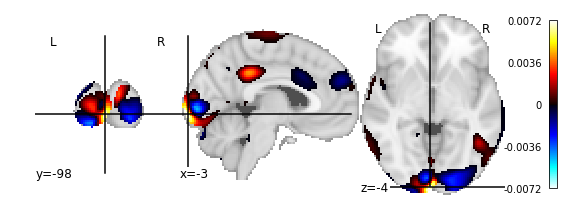

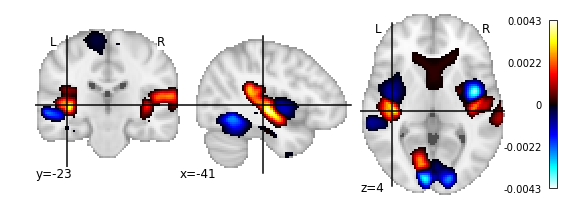

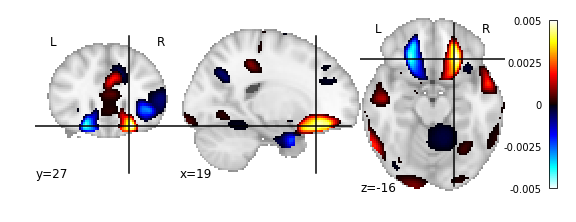

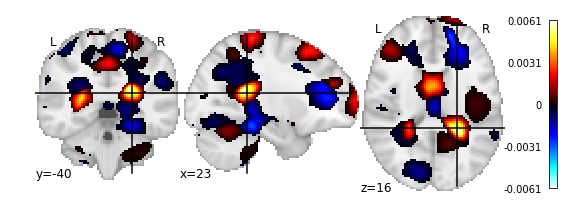

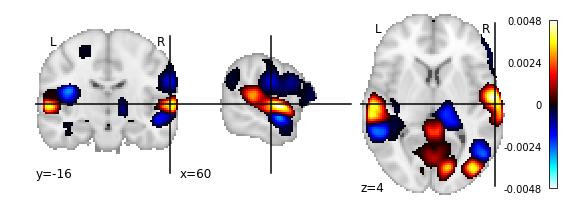

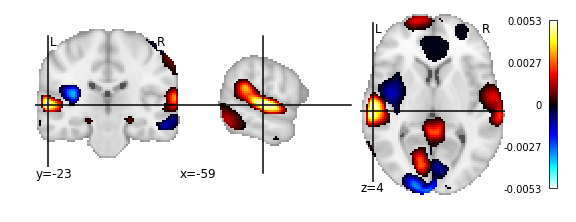

In [44]:
for i, j in indices[:30]:
    print(mean[i, j])
    vmax = np.abs(components[i][j]).max()
    img = masker.inverse_transform(components[i][j])
    cut_coords = find_xyz_cut_coords(img, activation_threshold=vmax/3)
    plot_stat_map(img, cut_coords=cut_coords)

In [22]:
plt.show()

NameError: name 'plt' is not defined

In [45]:
np.mean(stabilities.mean(axis=1))

0.2505546784953266

In [5]:
from cogspaces.datasets.dictionaries import fetch_atlas_modl

ref = fetch_atlas_modl()['components128']
ref = masker.transform(ref)=

________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0., ..., 0.], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f0e8b39ca90>)
___________________________________________________________unmask - 0.0s, 0.0min


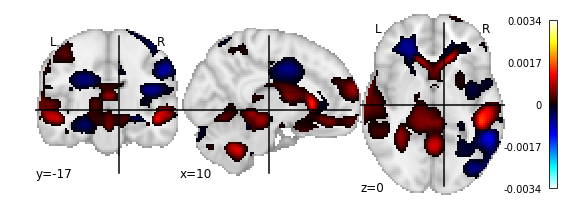

In [18]:
plot_stat_map(masker.inverse_transform(components[0][0]))

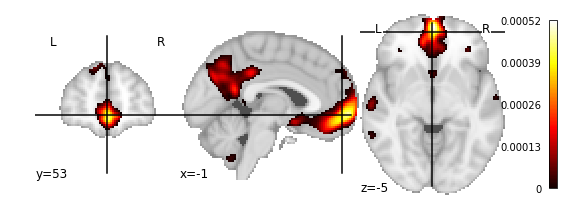

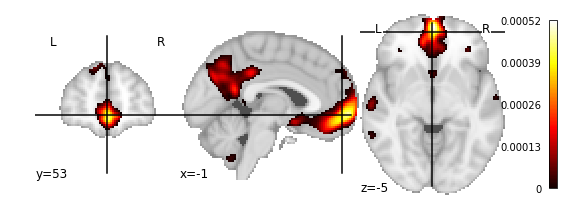

In [19]:
plot_stat_map(masker.inverse_transform(ref[0]))
plot_stat_map(masker.inverse_transform(ref[0]))

In [11]:
stability, assign = relative_stability(components[0], ref)

In [12]:
components_ass = components[0][assign]

In [13]:
import matplotlib.pyplot as plt

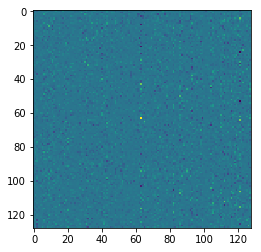

In [14]:
plt.imshow(components_ass.dot(ref.T))